# Signal/Background Classification using Boosted Decision Trees

**Used RandomUnderSampler to make the number of signal and background instances equal for training dataset.**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler

seed = 1234
np.random.seed(seed)

In [7]:
import os
print(os.getcwd())

/teamspace/studios/this_studio/all/BDT/DifferentAxionMass


## 1. Data Loading

In [8]:
ax75_data = pd.read_csv('/teamspace/studios/this_studio/all/BDT/DifferentAxionMass/ax75_signalBackground_2j1p_invMass_deltaR_data.txt', 
                     sep = '\t')

In [9]:
ax75_data.head()

,Unnamed: 0,eventno,jetmultiplicity,event_label,num_btag_jets,num_isophoton,jet1_Eta,jet1_Phi,jet1_pT,jet1_Px,...,jet2_E,isophoton1_Eta,isophoton1_Phi,isophoton1_pT,isophoton1_Px,isophoton1_Py,isophoton1_Pz,isophoton1_E,inv_mass_2j1p,deltaR_j1j2
0,0,54229.0,2.0,0.0,2.0,1.0,-0.452222,0.645538,26.0517,20.80950,...,27.5445,-0.476993,-1.66211,27.4569,-2.503820,-27.34250,-13.59910,30.6402,76.497345,1.729497
1,1,451531.0,2.0,0.0,2.0,1.0,-0.319102,-1.892100,27.9884,-8.83895,...,34.6989,-0.250455,1.85829,28.0520,-7.954070,26.90070,-7.09946,28.9365,81.254966,0.849681
2,2,29203.0,2.0,0.0,2.0,1.0,0.750920,-2.306760,66.2397,-44.46700,...,0.0000,0.490037,1.60387,27.8527,-0.921051,27.83750,14.20170,31.2644,80.421951,2.425907
3,3,52691.0,2.0,1.0,2.0,1.0,1.479940,-0.827068,51.1242,34.61300,...,118.0260,-0.107709,-2.97132,15.9033,-15.673400,-2.69486,-1.71624,15.9957,123.826058,2.981831
4,4,238096.0,3.0,0.0,2.0,1.0,2.199850,-0.426989,53.9469,49.10340,...,55.9621,1.153420,2.21908,36.4435,-22.005300,29.04980,51.99460,63.4946,272.110419,4.662546


In [10]:
ax75_data = ax75_data.drop(['Unnamed: 0'], axis = 1)

In [11]:
features_col = ['isophoton1_pT', 'inv_mass_2j1p', 'deltaR_j1j2']


X, y = ax75_data.loc[:,features_col].values, ax75_data.loc[:,'event_label'].values.astype(int)

In [12]:
from collections import Counter
Counter(y)[0]
print(f"Counts:"
     f"\n    Signal: {Counter(y)[1]}"
f'\n    Background: {Counter(y)[0]}')

Counts:
    Signal: 4790
    Background: 1912


## 2. Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=seed,
                                                   stratify = y)

## 3. Under Sampling the dominant class

In [14]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=seed)

print("\n--- Applying RandomUnderSampler to Training Data ---")
# Fit the sampler and resample the training data ONLY
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print(f"Original training features shape: {X_train.shape}")
print(f"Resampled training features shape: {X_train_resampled.shape}")
print(f"Resampled training target distribution: {Counter(y_train_resampled)}")


--- Applying RandomUnderSampler to Training Data ---
Original training features shape: (4691, 3)
Resampled training features shape: (2676, 3)
Resampled training target distribution: Counter({0: 1338, 1: 1338})


# Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
param_grid_forest = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=seed),
                          param_grid=param_grid_forest,
                          cv=5,
                          n_jobs=-1)

In [17]:
grid_search_forest.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200, 300, 500]})

Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 20, 'n_estimators': 500}


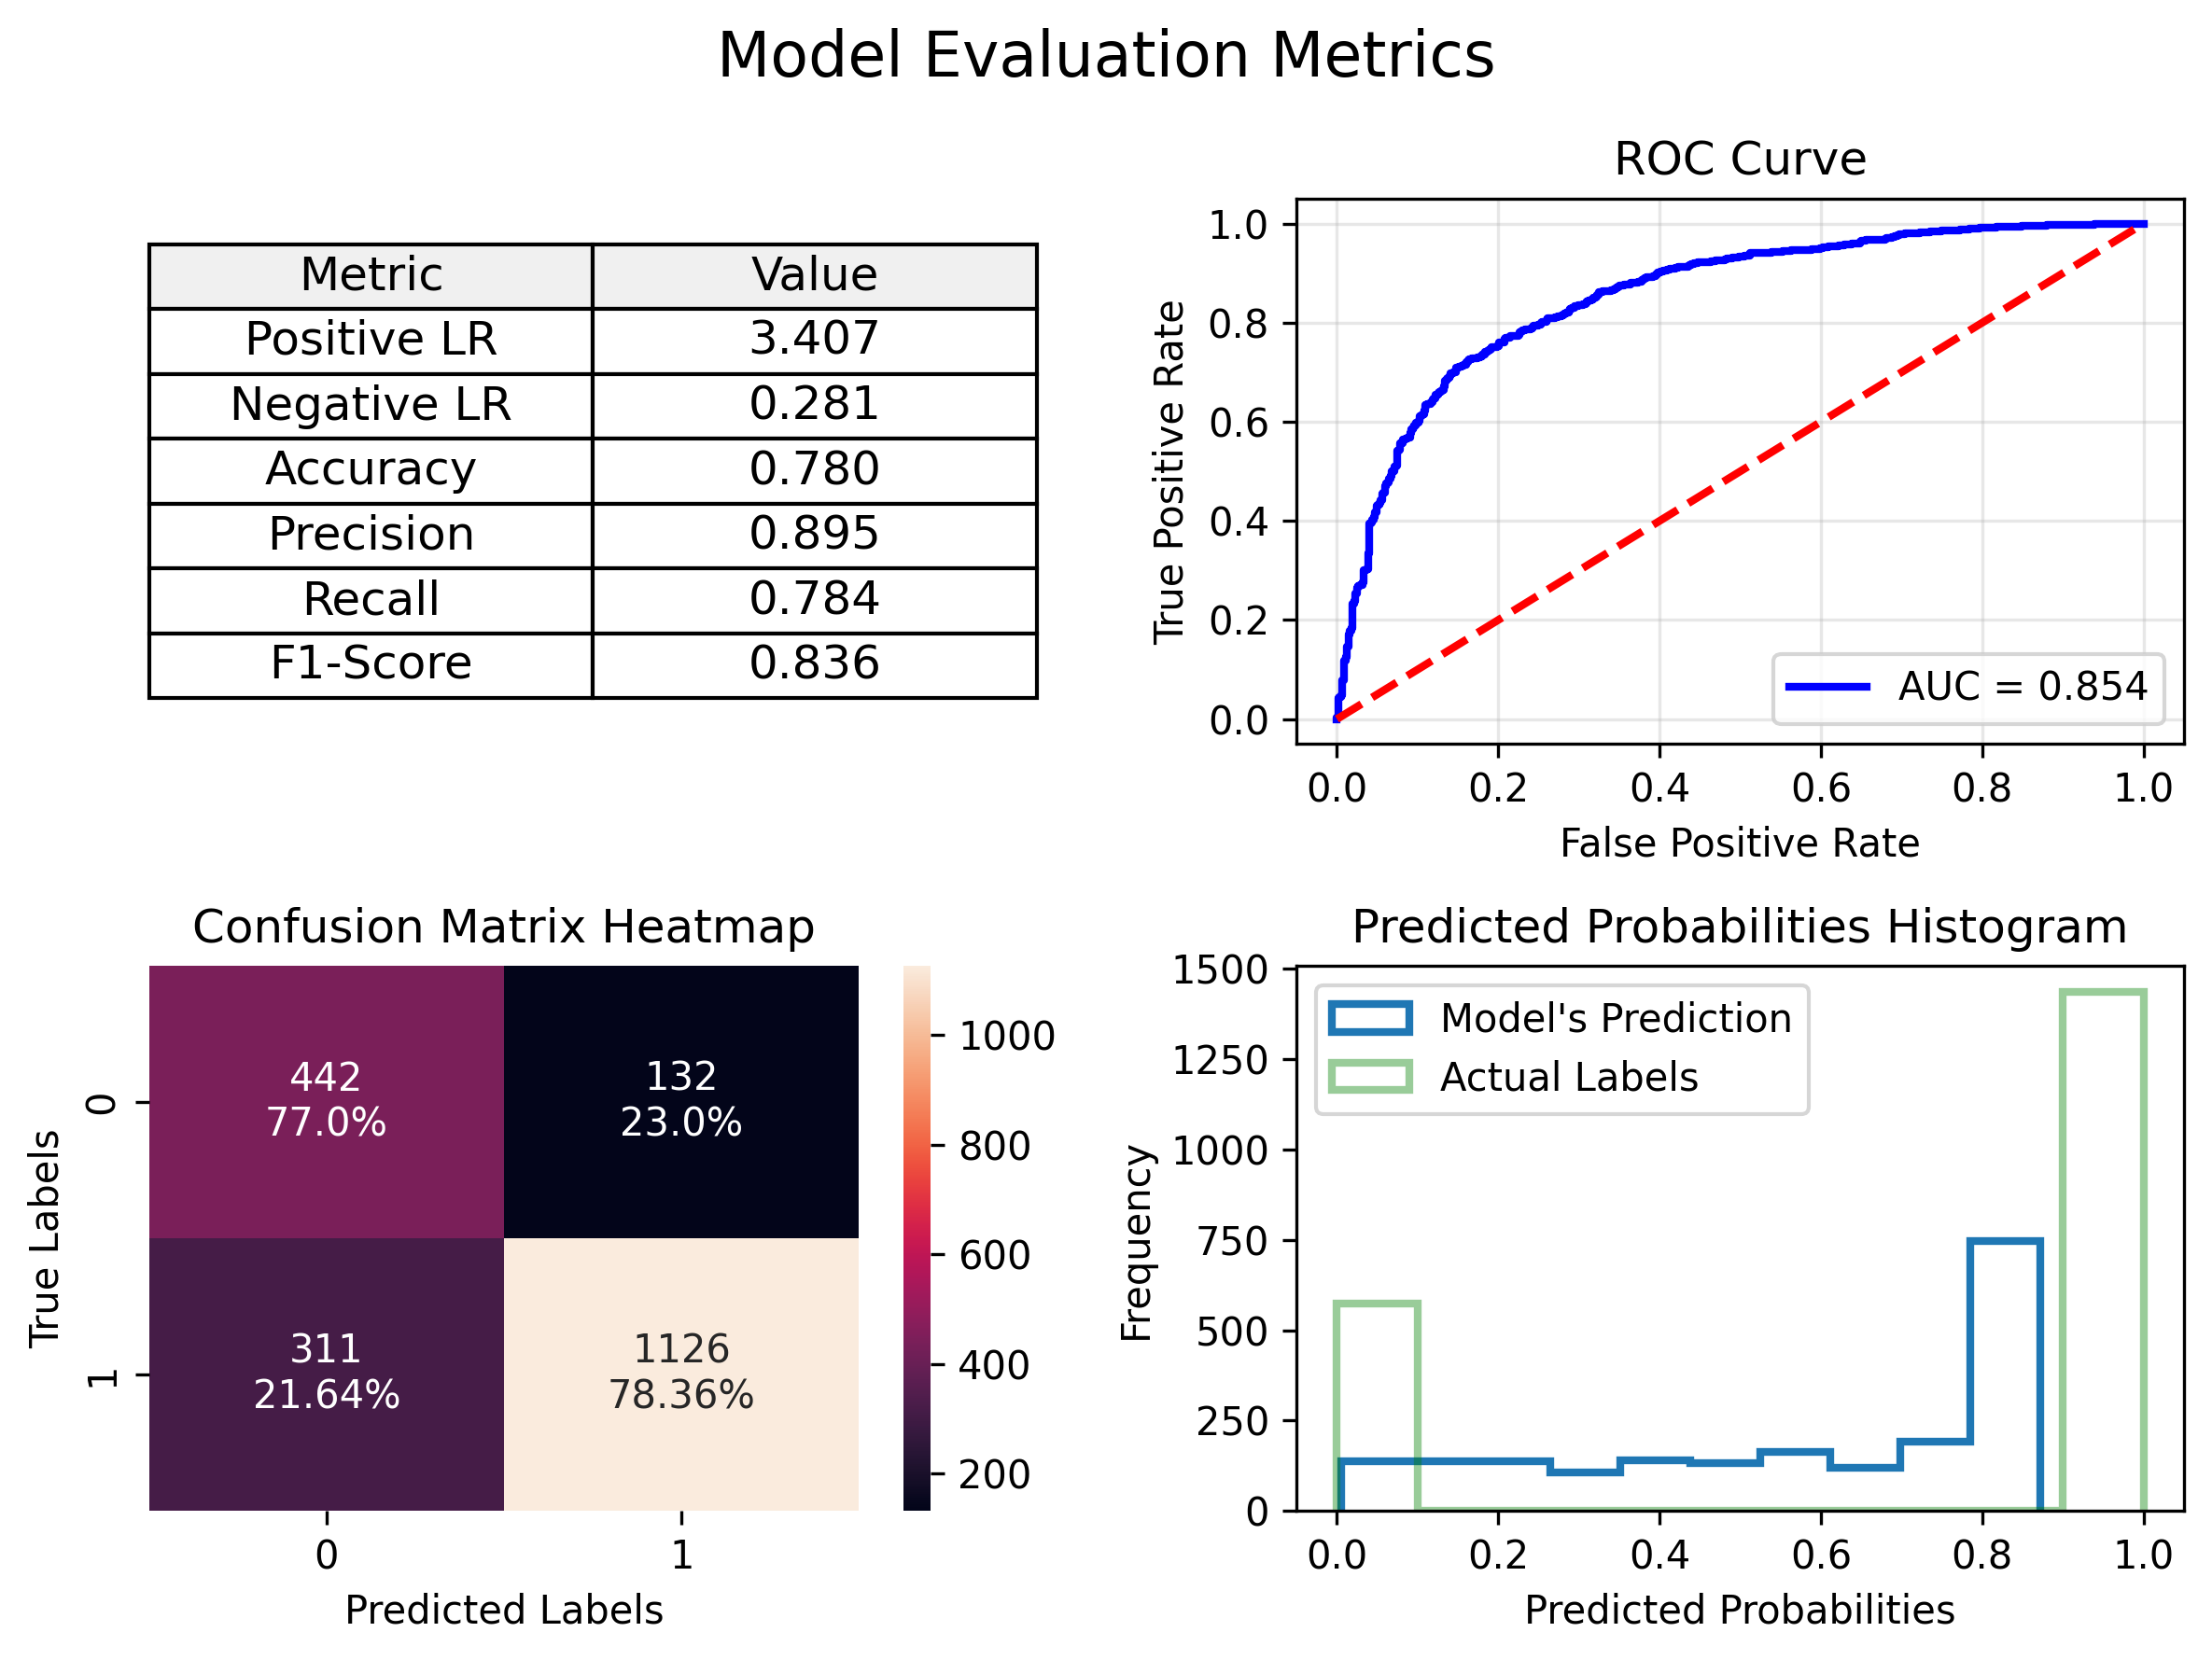

In [18]:
from helper_function_module import eval_model
best_model = grid_search_forest.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1


print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

y_pred_label = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob]
eval_model(y_test, y_pred_prob, y_pred_label, save_fig = False, save_fig_path = 'ax75_RFEval_Metrics.png')

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

Precision-Recall AUC: 0.9247


# Gradient Boosting Classifier

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
param_grid_grad = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

In [18]:
grid_search_grad = GridSearchCV(GradientBoostingClassifier(random_state=seed),
                          param_grid=param_grid_grad,
                          cv=5,
                          n_jobs=-1)

In [19]:
grid_search_grad.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}


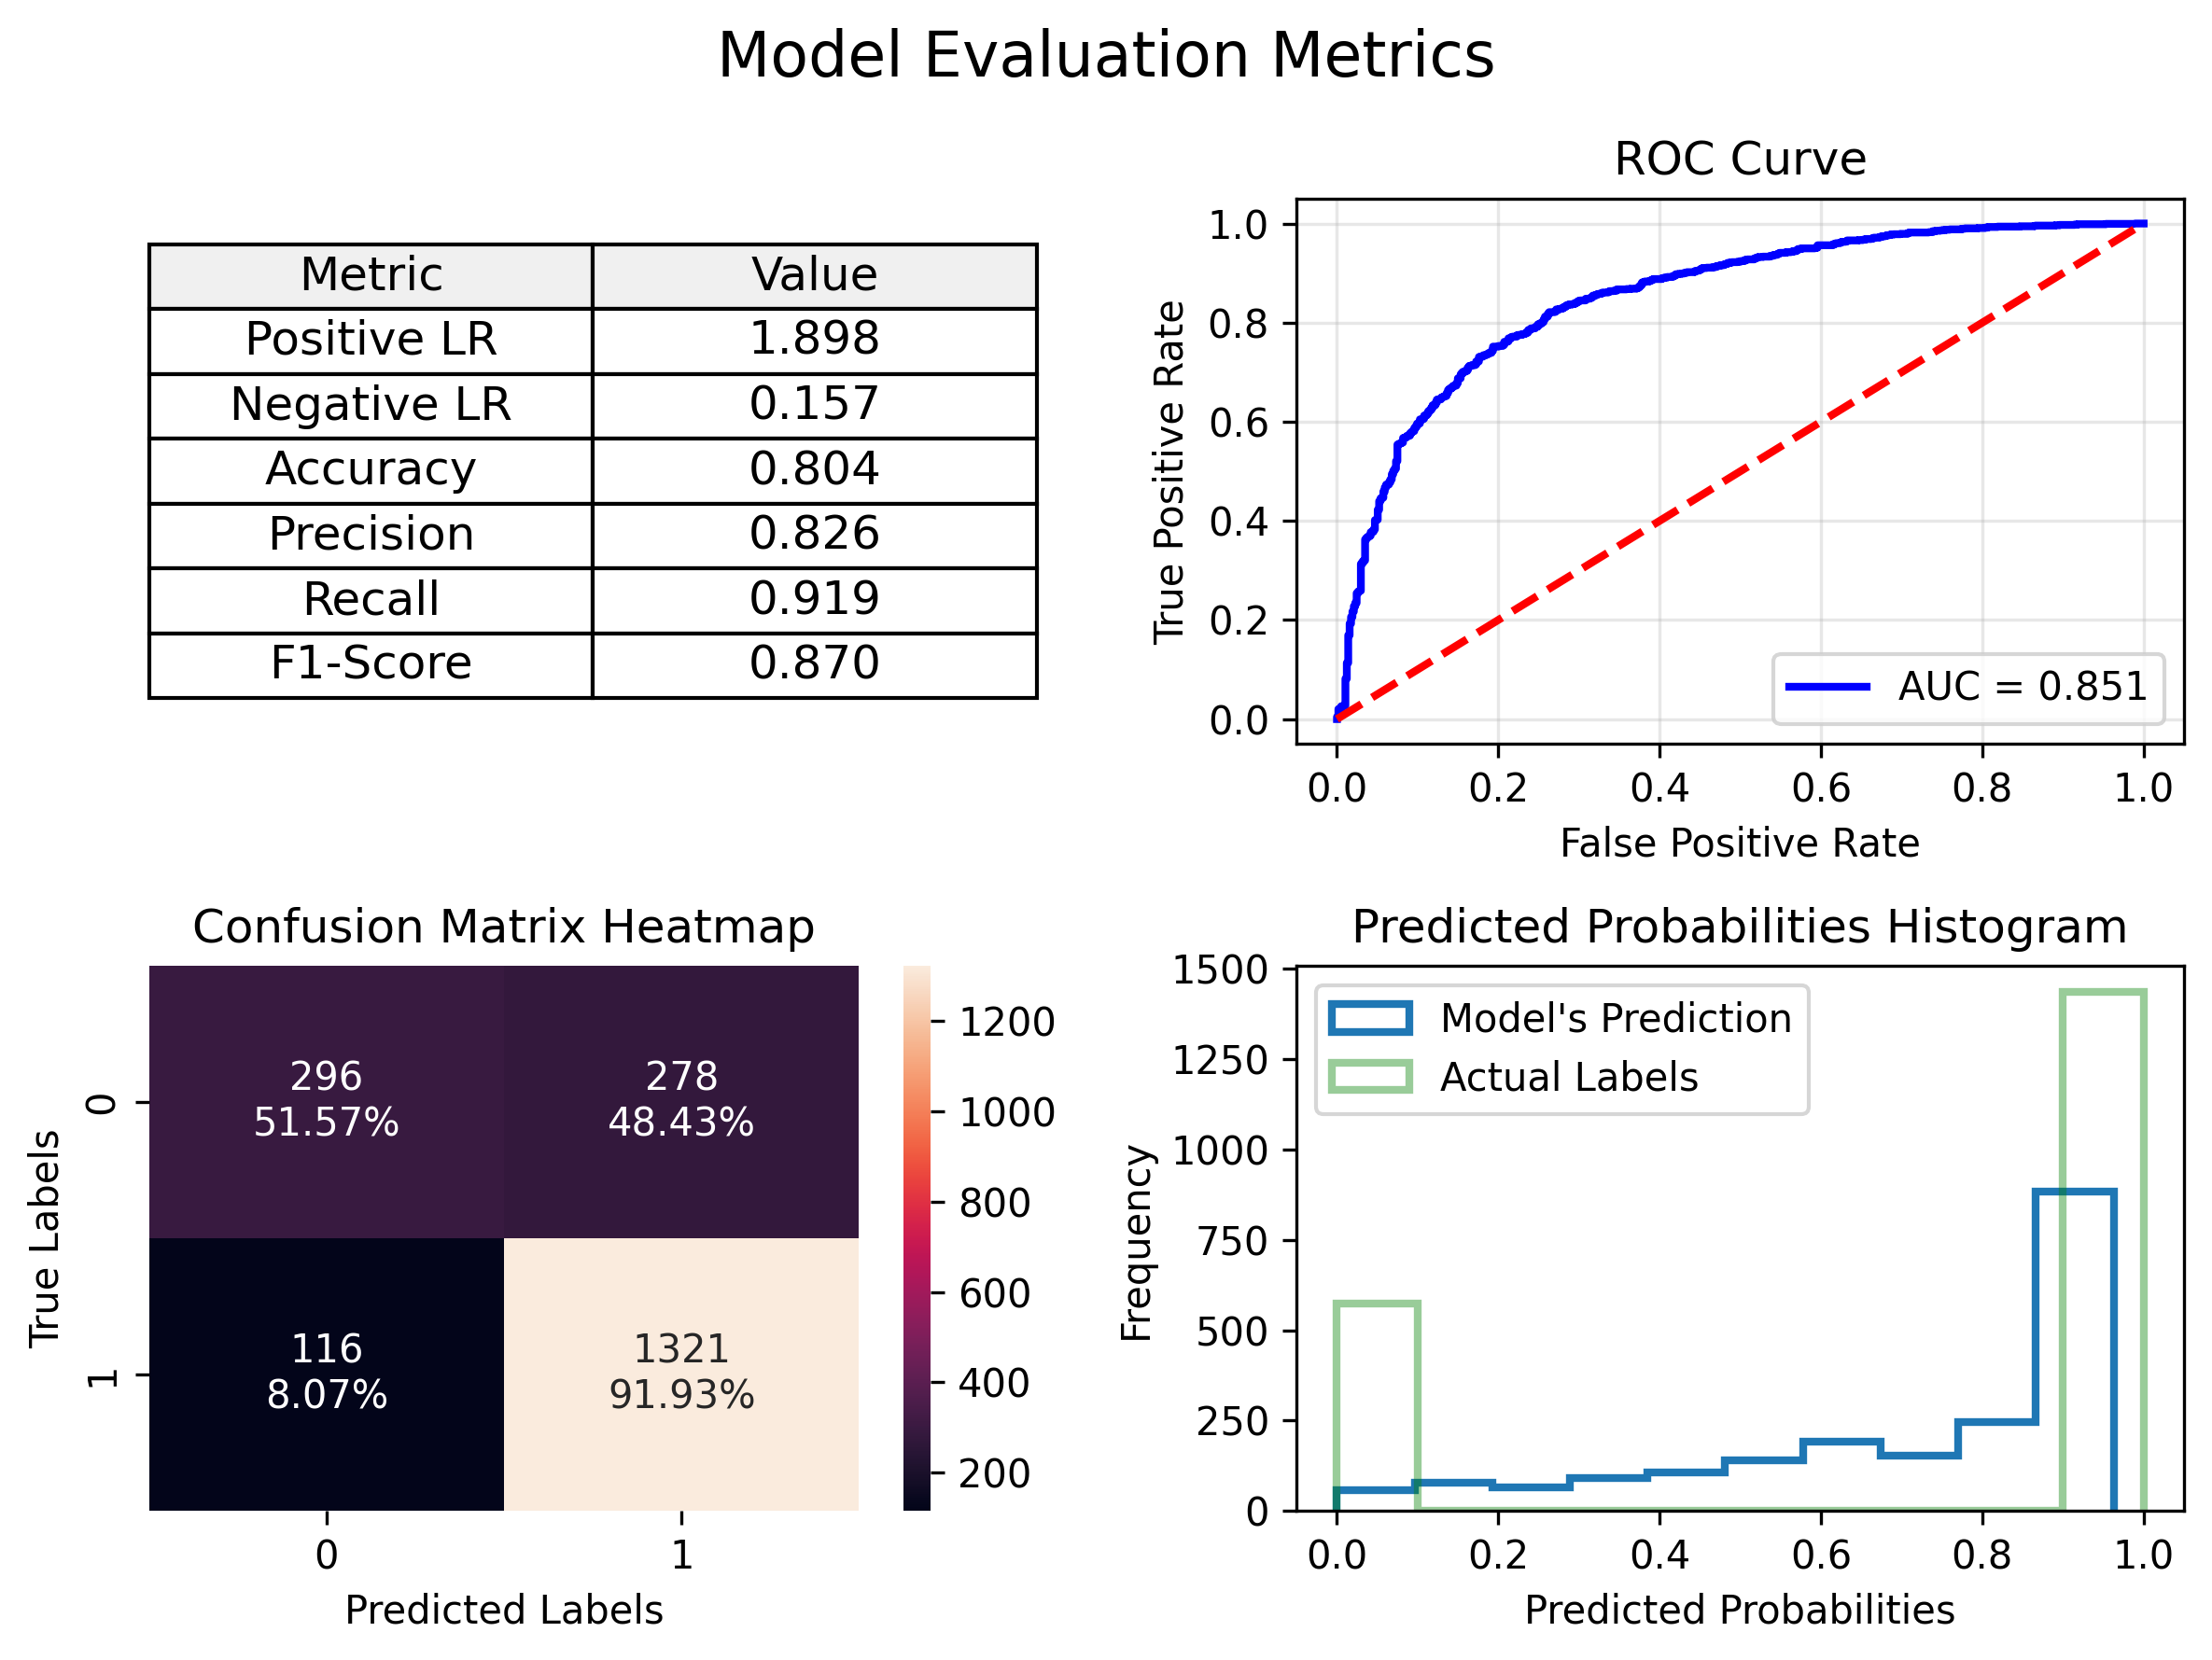

In [20]:
from helper_function_module import eval_model
best_model = grid_search_forest.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1

print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

y_pred_label = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob]
eval_model(y_test, y_pred_prob, y_pred_label, save_fig = False, save_fig_path = 'ax75_GBEval_Metrics.png')